In [2]:
import os
import tarfile
import urllib.request
import tensorflow as tf
from tensorflow import keras
import matplotlib.pylab as plt
import pandas_datareader as pd
import numpy as np

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
#8个输入特征，一个标签即房屋价值中间值
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()#归一化，得到数据的特征如均值、方差等
scaler.fit(X_train)
X_mean = scaler.mean_#均值
X_std = scaler.scale_#方差

In [4]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)
median_income = tf.feature_column.numeric_column("median_income")

bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

### 使用独热向量编码分类特征

#### 使用查找表为特征进行编码

若查找词汇表中不存在的类别，则计算该类别的哈希值并将这个未知类别分配给oov桶中的一个，oov桶的索引从已知类别开始

In [5]:
vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

#创造有相应索引的张量
indices = tf.range(len(vocab),dtype=tf.int64)

#创建一个初始化程序，将类别列表和对应的索引传递
table_init = tf.lookup.KeyValueTensorInitializer(vocab,indices)

num_oov_buckets = 2#词汇表外桶的数量

table = tf.lookup.StaticVocabularyTable(table_init,num_oov_buckets)#创建查找表

### 使用查找表将一小批分类特征编码为one-hot向量

In [6]:
categories = tf.constant(["NEAR BAY","DESERT","INLAND","INLAND"])
cat_indices = table.lookup(categories)
cat_indices 

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

In [7]:
cat_one_hot=tf.one_hot(cat_indices,depth=len(vocab)+num_oov_buckets)
cat_one_hot#NEAR BAY映射到3，未知类别DESERT被映射到5（两个oov桶之一）

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

### 使用keras实现单词级的one-hot编码

In [15]:
#用Kears实现单词级的one-hot编码
from keras_preprocessing.text import Tokenizer#tokenizer是一个分词器
samples=["The cat sat on the mat","The dog ate my homework"]
tokenizer=Tokenizer(num_words=1000)#设置只考虑前1000个单词
tokenizer.fit_on_texts(samples)#构建单词索引
sequences=tokenizer.texts_to_sequences(samples)#句子中的单词转化成为以单词索引如“[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]”
print(sequences)

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]


In [16]:
one_hot_results=tokenizer.texts_to_matrix(samples,mode="binary")#进行one_hot编码
print(one_hot_results)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [17]:
word_index=tokenizer.word_index#查看对应单词和数字的对应关系
print(word_index)

{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}


## 使用嵌入编码分类特征
如果类别数小于10通常使用独热编码，类别数大于50时最好使用嵌入，此时通常需使用哈希桶

嵌入表示类别可训练密集向量，默认情况下是随机初始化的，其维度是可调整的超参

In [9]:
vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

embedding_dim = 2 #使用2D嵌入
#创建一个包含每个类别嵌入的嵌入矩阵，并随机初始化
embed_init = tf.random.uniform([len(vocab)+num_oov_buckets,embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In [10]:
embedding_matrix #（7,2）的嵌入矩阵，存储在变量中使其可以在训练过程中进行调整

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.18901992, 0.7770935 ],
       [0.20179975, 0.08300161],
       [0.71197236, 0.9925529 ],
       [0.5039997 , 0.04475331],
       [0.6017029 , 0.7671175 ],
       [0.33716547, 0.10470724],
       [0.33718455, 0.19313765]], dtype=float32)>

In [11]:
categories = tf.constant(["NEAR BAY","DESERT","INLAND","INLAND"])
cat_indices = table.lookup(categories)
cat_indices 

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 5, 1, 1])>

#### *tf.nn.embedding_lookup()*:以给定的索引查找在嵌入矩阵中的行

In [12]:
tf.nn.embedding_lookup(embedding_matrix,cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.5039997 , 0.04475331],
       [0.33716547, 0.10470724],
       [0.20179975, 0.08300161],
       [0.20179975, 0.08300161]], dtype=float32)>

### 使用keras实现Embedding编码

#### keras.utils.pad_sequences():将长短不一的输入转化成矩阵

In [19]:
#使用词嵌入
#利用Embedding层学习词嵌入
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten,Dense,Embedding

max_features=10000 #设置10000个单词作为特征单词的数量
max_len=20 #设置20个单词为考察对象，只考虑句子的前20个单词
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)#获取数据集imdb
#这里是把训练集和测试集转换为形状为（samples,maxlen）的二维整数张量
x_train=pad_sequences(x_train,maxlen=max_len)#将前20个单词作为考察对象
x_test=pad_sequences(x_test,max_len)

#构建模型
model=Sequential()

#Embedding层就像一个字典，根据单词序号返回对应的词向量
#参数的含义是输入形状为10000,长度为20，宽度为8的数据
model.add(Embedding(10000,8,input_length=max_len))

model.add(Flatten())#将数据转换成10000,20×8的二维数据

#接上全链接层分类
model.add(Dense(1,activation="sigmoid"))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [20]:
#epochs表示训练数据被使用的次数，一个epoch表示优化算法将全部数据使用了一次
#batch_size表示每次迭代都使用32个样本,validation_split表示验证集的大小为0.2
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6679 - acc: 0.6306 - val_loss: 0.6180 - val_acc: 0.6978
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5419 - acc: 0.7527 - val_loss: 0.5273 - val_acc: 0.7322
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4604 - acc: 0.7894 - val_loss: 0.5004 - val_acc: 0.7430
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4193 - acc: 0.8112 - val_loss: 0.4939 - val_acc: 0.7460
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3909 - acc: 0.8249 - val_loss: 0.4934 - val_acc: 0.7544
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3677 - acc: 0.8383 - val_loss: 0.4971 - val_acc: 0.7488
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3474 - acc: 0.8494 - val_loss: 0.5018 - val_acc: 0.7510
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.

### 构建keras模型
该模型可以处理分类特征以及常规的数值特征，并学习每个类别（及每个oov桶）的嵌入

In [14]:
regular_inputs = keras.layers.Input(shape=[8]) #每个实例8个数字特征
categories = keras.layers.Input(shape=[],dtype=tf.string) #每个实例1个分类特征
#查找每个类别的索引和索引的嵌入
cat_indices = keras.layers.Lambda(lambda cats:table.lookup(cats))(categories)
#将分类特征编码为嵌入变量
cat_embed = keras.layers.Embedding(input_dim=6,output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs,cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs,categories],
               outputs=[outputs])

## TF数据集项目
数据集中每个项目都包含特征和标签的字典





#### tfds.load（）：下载Tensorflow内置的数据集，将数据作为数据集的目录返回。对下载的每个数据碎片进行乱序（仅针对训练集）

In [21]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [22]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'bair_robot_pushing_small', 'bccd', 'beans', 'bee_dataset', 'beir', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bucc', 'c4', 'c4_wsrs', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cardiotox', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar100_n', 'cifar10_1', 'cifar10_corrupted', 'cifar10_n', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'conll2002', 'conll2003', 'controlled_noisy_web_labels', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d

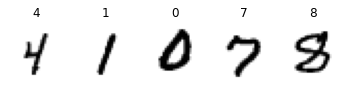

In [23]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [24]:
#转换数据
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))#转换数据集
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 32.1714 - accuracy: 0.8427
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 25.8446 - accuracy: 0.8693
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 24.7782 - accuracy: 0.8731
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.1291 - accuracy: 0.8769
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 23.7757 - accuracy: 0.8777
